In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess
import src.data_raw as data_raw

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


# TODO:

- Refine data processing to support minute granularity as well (if memory hold, otherwise skip and handle through print messages)
- Experiment with multi-envs:
    * https://stable-baselines.readthedocs.io/en/master/guide/examples.html?highlight=set_global_seeds#multiprocessing-unleashing-the-power-of-vectorized-environments
    * Notes: https://github.com/hill-a/stable-baselines/issues/334, https://github.com/hill-a/stable-baselines/issues/166, https://github.com/hill-a/stable-baselines/issues/308
    - Consider this as two separate points for MLP and LSTM. Different requirements (see other point)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html. Will need to assess if model is still unstable.
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt. Some Medium articles uses Sharpe values, investigate.
- Download all transactions -> render OHLC in multiple time granularities
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- self.stationarize_rewards?
- Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Hyperparameter search
- Explore different gamma (Discount factor)
- Checkout frame stacking as a poor man's lstm (unlikely that it's useful, since we're dealing with time series)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better (need to understand terminology surronding it, e.g. environment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- understand the rendering during learning (prob need to read the code to understand all callback fields)
- untangle index weirdness (basically, try to enable prediction the last timestep, and make running interface easier (and more robust))
    * Check info box for reason and solution: https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html
    * This might also help (at the end) https://github.com/hill-a/stable-baselines/issues/779
    * LOW PRIO, since we might change the padding structure if we apply LSTM policy network

- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks

# Run

In [10]:
#config.input_data.source = 'Bitstamp' #Coinbase, Gemini, Kraken

In [18]:
%%time
data_raw.download_and_process()
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df)
env = run.setup_env(df=df)
timesteps = config.train_predict.train_timesteps
model = run.train(env=env, timesteps=timesteps)

hey
LOAD: Loading data with 312931 samples
PREPROCESS: Dropping 0 NaNs out of 312931 samples (0.0%) from input file
PREPROCESS: Dropping unused data, 312931 -> 3510 samples
PREPROCESS: Adding technical features...
Done.

Resetting to timesteps: start 309463, end 312430.
RUN: Training for 3000 timesteps...




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Resetting to timesteps: start 309463, end 312430.
--------------------------------------
| approxkl           | 0.00016412119 |
| clipfrac           | 0.0           |
| explained_variance | 0.118         |
| fps                | 149           |
| n_updates          | 1             |
| policy_entropy     | 2.1971056     |
| policy_loss        | -0.008582531  |
| serial_timesteps   | 128           |
| time_elapsed       | 2.69e-05      |
| total_timest

RUN: Loading files from /tmp/
Loading a model without an environment, this model cannot be trained until it has a valid environment.
RUN: Model connected with env
RUN: Predicting for 489 timesteps
Resetting to timesteps: start 1990200, end 1990690.
Rendering TradingChartStatic for index steps 1990200 through 1990689
Not rendering trades since they are too many to distinguish in plot (489)


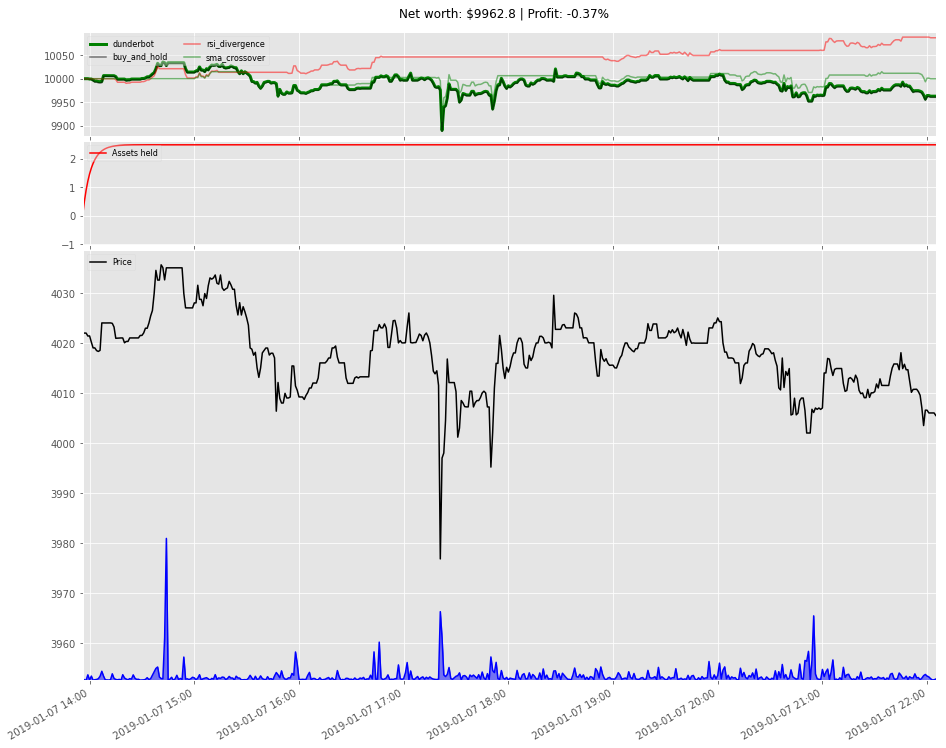

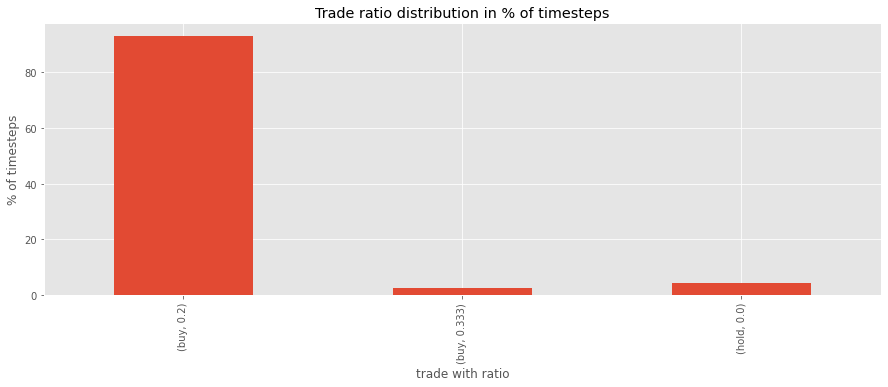

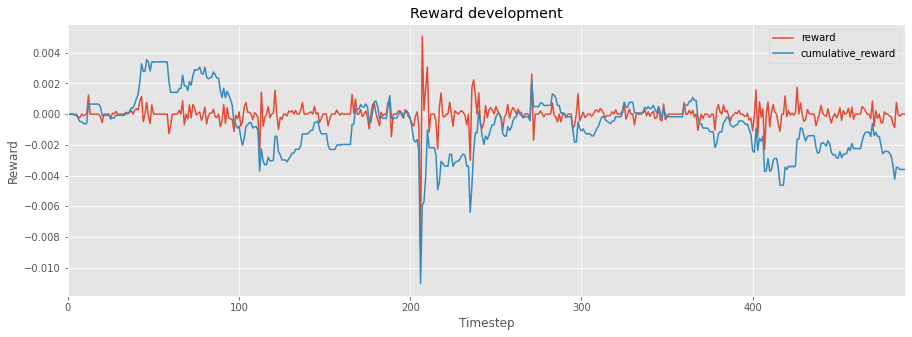

CPU times: user 4.81 s, sys: 351 ms, total: 5.16 s
Wall time: 4.7 s


In [3]:
%%time
timesteps = config.train_predict.predict_timesteps - config.data_params.data_n_timesteps - 1
run.predict(df=df, timesteps=timesteps, rendermode='human')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 18,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10001.7,
  9993.31,
  9845.08,
  9818.83,
  9857.64,
  9811.18,
  9826.9,
  9849.13,
  9841.65,
  9846.6,
  9906.72,
  9857.82,
  9825.55,
  9844.28,
  9835.73,
  9843.79,
  9853.91,
  9847.28,
  9858.84,
  9884.08,
  9846.62,
  9846.11,
  9859.04,
  9865.74,
  9849.82,
  9871.96,
  9886.04,
  9852.41,
  9828.36,
  9781.67,
  9796.26,
  9789.61,
  9787.16,
  9798.66,
  9821.71,
  9819.04,
  9825.21,
  9813.02,
  9817.28,
  9809.9,
  9810.35,
  9815.73,
  9852.16,
  9844.47,
  9845.15,
  9833.28,
  9836.58,
  9863.32,
  9843.26,
  9846.9,
  9838.6,
  9843.73,
  9840.44,
  9971.54,
  9981.18,
  9980.54,
  9981.68,
  9980.22,
  9984.06,
  10005.04,
  9992.58,
  9998.53,
  10012.4,
  10006.93,
  9995.75,
  9951.78,
  9922.8,
  9824.37,
  9840.96,
  9803.94,
  9764.1,
  9780.03,
  9798.29,
  9787.19,
  9793.24,
  9805.33,
  9789.97,
  9796.14,
  9795.5,
  9814.97,
  9812.16,
  9803.83,
  9817.89,
  9804.12,
  9807.79,
  9

In [8]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])